# Tutorial: Graph Coloring with (quantum) column generation algorithm

## Reduced Master Problem (RMP) and Column Generation Algorithms 

The Reduced Master Problem is an algorithm introduced by Wesley da Silva Coelho et al. [2301.02637](https://arxiv.org/abs/2301.02637) as a quantum-enhanced column generation method. Their quantum-classical hybrid algorithm are especially suitable for solving combinatorial optimization problems using neutral atom quantum computers. 

Column generation itself is an iterative optimization methodology designed to tackle linear programming problems with an overwhelmingly large number of variables, often referred to as "columns." In such cases, considering all variables explicitly becomes computationally infeasible. The RMP is a constrained version of the original problem, formulated using only a limited subset of these variables. This restriction is not a limitation, but rather the key to the column generation approach. By starting with a manageable set of columns, the algorithm iteratively approaches a solution for problems with a prohibitively large number of potential options. The RMP serves two primary functions: it provides the current best solution given the available columns and generates dual variables that guide the search for new, beneficial columns in a related sub-problem called the Pricing Sub-Problem (PSP). The interaction between the RMP and the PSP is cyclical and forms the core of the column generation process. The RMP is solved; the dual variables from its solution are passed to the PSP; the PSP attempts to generate new columns that would improve the RMP's objective function. If found, these new columns are added to the RMP, and the process repeats.

In the initial formulation of the RMP, we begin with a subset of variables, denoted as S', that must guarantee a feasible solution to the RMP. This initial feasibility is crucial for the algorithm to proceed. In the context of MVCP, where columns represent independent sets of vertices, a trivial but effective way to build the initial set S' is to include only the singletons, where each vertex is an independent set of size one. This ensures that every vertex has a color assigned, providing a feasible starting point for the optimization. Mathematically, the RMP for MVCP can be formulated with the objective of minimizing the number of selected independent sets, represented by the equation:

$$\min \sum_{s \in S'} y_s $$

This aims to minimize the total number of colors used. The constraints ensure that every vertex 'u' in the graph's vertex set 'V' is covered by exactly one selected independent set from S':

$$\sum_{s \in S'} b_{us} y_s = 1, \quad \forall u \in V $$

Here, $b_{us}$ is a binary parameter that equals 1 if vertex 'u' is in independent set 's', and 0 otherwise. During the iterative phase, the variables $y_s$, which indicate whether independent set 's' is chosen, are relaxed to be continuous between 0 and 1:

$$0 \leq y_s \leq 1, \quad \forall s \in S' $$

In each iteration of the column generation procedure, the RMP, as defined by equations (9)-(11), is solved in its linear relaxation form, typically by a classical linear programming (LP) solver. Solving the RMP as a linear relaxation is a crucial choice that allows for the extraction of dual variables from the LP solution. These dual variables are essential for guiding the PSP. Dual variables, denoted as $w_u$, represent the economic incentive for satisfying the constraints of the RMP. For MVCP, the PSP is often formulated as a Maximum Weighted Independent Set (MWIS) problem. The objective of this MWIS problem is to find an independent set $s^*$ that maximizes the sum of the dual variables of its constituent vertices:

$$\max \sum_{u \in V} (w_u \cdot x_u) $$

where $x_u$ is 1 if vertex 'u' is in the independent set and 0 otherwise. The reduced cost $r_s$ of a potential new column (independent set 's') is calculated as:

$$r_s = 1 - \sum_{u \in V} (w_u \cdot x_u) $$

A new column is deemed beneficial if its reduced cost is negative ($r_s < 0$), which is equivalent to the sum of the dual variables for the vertices in the independent set being greater than 1.

If the PSP identifies one or more beneficial independent sets, these are added as new columns to the RMP's set of active variables S', and the RMP is resolved. This iterative loop continues until the PSP cannot find any new columns with a negative reduced cost, indicating that the current RMP solution is optimal for the available columns. At this point, the integrality constraints on the $y_s$ variables are re-imposed ($y_s \in \{0, 1\}$), and the RMP is solved as an Integer Linear Program (ILP) to obtain the final integer solution. This solution is optimal with respect to the generated set S', but not necessarily the global optimum. In the hybrid quantum-classical framework, the RMP itself is solved using a classical solver, while the PSP, which often involves solving an NP-hard problem like MWIS, can leverage quantum computation for potential speedup or better solutions. This approach aims to combine the strengths of both classical and quantum computing paradigms, applying quantum resources specifically to the most challenging part of the algorithm.




## Classical Solver

Let's first demonstrate the algorithm and workflow with classical solvers (with scipy linear programming solver `linprog` and mixed-integer LP solver `milp`)

In [1]:
import numpy as np
from scipy.optimize import linprog, milp, OptimizeWarning
from scipy.sparse import lil_matrix
from collections import namedtuple
import warnings
import networkx as nx
import matplotlib.pyplot as plt

# Suppress warnings from linprog/milp if they are too verbose for a tutorial
warnings.filterwarnings("ignore", category=OptimizeWarning)

In [2]:
def plot_graph(graph, title="Graph", node_colors=None, pos=None):
    """
    Plots the graph using networkx and matplotlib.
    If node_colors is provided, it should be a list or array of colors
    corresponding to the nodes in G.nodes().
    """
    if pos is None:
        pos = nx.spring_layout(graph, seed=42) # for consistent layout

    plt.figure(figsize=(8, 6))

    if node_colors:
        # Ensure node_colors is a list if it's a dict mapping nodes to colors
        if isinstance(node_colors, dict):
            color_map = [node_colors.get(node, 'lightgray') for node in graph.nodes()]
        else:
            color_map = node_colors
        nx.draw(graph, pos, with_labels=True, node_color=color_map, node_size=700, font_size=10, font_weight='bold', edge_color='gray')
    else:
        nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=10, font_weight='bold', edge_color='gray')

    plt.title(title)
    plt.show()

In [3]:
def solve_mvcp_column_generation(G, graph_name="Graph"):
    """
    Solves the Minimum Vertex Coloring Problem (MVCP) using column generation.
    """

    # 1. Graph Definition (Example from Figure 2 of the paper)
    # num_vertices = 5
    # edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]
    # vertices = list(range(num_vertices))
    num_vertices = G.number_of_nodes()
    original_nodes = sorted(list(G.nodes()))
    node_to_idx = {node: i for i, node in enumerate(original_nodes)}
    idx_to_node = {i: node for i, node in enumerate(original_nodes)}
    mapped_edges = [(node_to_idx[u], node_to_idx[v]) for u, v in G.edges()]
    edges = mapped_edges

    print(f"Solving MVCP for a graph with {num_vertices} vertices and {len(edges)} edges.")
    # print(f"Vertices: {vertices}")
    # print(f"Edges: {edges}\n")

    # Create a NetworkX graph object
    # G = nx.Graph()
    # G.add_nodes_from(vertices)
    # G.add_edges_from(edges)

    # Store a layout for consistent plotting
    graph_layout = nx.spring_layout(G, seed=42)

    # Plot initial graph
    plot_graph(G, title="Initial Graph", pos=graph_layout)

    # 2. Initialization
    current_columns = [frozenset([i]) for i in range(num_vertices)]
    known_column_signatures = {tuple(sorted(list(s))) for s in current_columns}

    print(f"Initial columns (singleton independent sets): {current_columns}\n")

    max_iterations = 20
    epsilon = 1e-6

    for iteration in range(max_iterations):
        print(f"--- Iteration {iteration + 1} ---")
        num_current_columns = len(current_columns)

        # 3. Solve Restricted Master Problem (RMP) - LP Relaxation
        c_rmp = np.ones(num_current_columns)
        A_eq_rmp = np.zeros((num_vertices, num_current_columns))
        for s_idx, s_col in enumerate(current_columns):
            for vertex_in_col in s_col:
                A_eq_rmp[vertex_in_col, s_idx] = 1
        b_eq_rmp = np.ones(num_vertices)
        bounds_rmp = [(0, 1) for _ in range(num_current_columns)]

        print(f"  Solving RMP with {num_current_columns} columns...")
        rmp_result = linprog(c_rmp, A_eq=A_eq_rmp, b_eq=b_eq_rmp, bounds=bounds_rmp, method='highs')

        if not rmp_result.success:
            print("  RMP solution failed. Stopping.")
            # Attempt to plot current state before breaking if desired
            # plot_graph_with_coloring(G, {}, "RMP Failed State", graph_layout)
            break

        dual_variables = rmp_result.eqlin['marginals'] if rmp_result.eqlin is not None else np.zeros(num_vertices)
        # Handle cases where duals might not be available or are None
        if dual_variables is None or not hasattr(dual_variables, '__len__') or len(dual_variables) != num_vertices:
            print(f"  Warning: Dual variables not properly retrieved or have unexpected format. Using zeros. RMP status: {rmp_result.message}")
            dual_variables = np.zeros(num_vertices)


        print(f"  RMP Objective (sum of y_s, LP relaxed): {rmp_result.fun:.4f}")
        print(f"  Dual variables (weights for PSP): {np.round(dual_variables, 4)}")

        # 4. Solve Pricing Sub-Problem (PSP) - Maximum Weight Independent Set (MWIS)
        c_psp = -np.array(dual_variables)
        integrality_psp = np.ones(num_vertices, dtype=int)
        # bounds_psp = [(0, 1)] * num_vertices
        # Changed bounds_psp to a tuple of lists
        bounds_psp = ([0] * num_vertices, [1] * num_vertices)

        num_edges = len(edges)
        A_ub_psp = lil_matrix((num_edges, num_vertices), dtype=float)
        for i, edge in enumerate(edges):
            A_ub_psp[i, edge[0]] = 1
            A_ub_psp[i, edge[1]] = 1
        b_ub_psp = np.ones(num_edges)

        from scipy.optimize import LinearConstraint
        psp_constraints = [LinearConstraint(A_ub_psp.toarray(), -np.inf, b_ub_psp)]

        print(f"  Solving PSP (MWIS) to find a new column...")
        psp_result = milp(c=c_psp, constraints=psp_constraints, integrality=integrality_psp, bounds=bounds_psp)

        if not psp_result.success:
            print("  PSP solution failed. Stopping.")
            # plot_graph_with_coloring(G, {}, "PSP Failed State", graph_layout)
            break

        new_independent_set_indices = [v for v, val in enumerate(psp_result.x) if val > 0.5]
        new_independent_set = frozenset(new_independent_set_indices)

        psp_objective_value = -psp_result.fun

        print(f"  PSP found new potential independent set: {set(new_independent_set)}")
        print(f"  PSP objective value (sum of duals for this set): {psp_objective_value:.4f}")

        # 5. Check Stopping Criterion
        if psp_objective_value <= 1 + epsilon:
            print(f"\n  No more profitable columns found (PSP objective {psp_objective_value:.4f} <= 1). Stopping column generation.")
            break

        new_col_sig = tuple(sorted(list(new_independent_set)))
        if new_col_sig in known_column_signatures:
            print(f"\n  New column {set(new_independent_set)} is already known. Stopping to avoid cycling.")
            break

        # 6. Add New Column
        current_columns.append(new_independent_set)
        known_column_signatures.add(new_col_sig)
        print(f"  Adding new column: {set(new_independent_set)}. Total columns: {len(current_columns)}\n")

        if iteration == max_iterations - 1:
            print("\n  Reached max iterations. Stopping column generation.")
            break

    # 7. Final Solution - Solve RMP as ILP with all generated columns
    print("\n--- Solving Final RMP as Integer Linear Program ---")
    num_final_columns = len(current_columns)
    c_final_rmp = np.ones(num_final_columns)

    A_eq_final_rmp = np.zeros((num_vertices, num_final_columns))
    for s_idx, s_col in enumerate(current_columns):
        for vertex_in_col in s_col:
            A_eq_final_rmp[vertex_in_col, s_idx] = 1
    b_eq_final_rmp = np.ones(num_vertices)

    integrality_final_rmp = np.ones(num_final_columns, dtype=int)
    # bounds_final_rmp = [(0, 1)] * num_final_columns
    # Changed bounds_final_rmp to a tuple of lists
    bounds_final_rmp = ([0] * num_final_columns, [1] * num_final_columns)

    final_rmp_constraints = [LinearConstraint(A_eq_final_rmp, b_eq_final_rmp, b_eq_final_rmp)]

    final_rmp_result = milp(c=c_final_rmp, constraints=final_rmp_constraints, integrality=integrality_final_rmp, bounds=bounds_final_rmp)

    final_coloring_map = {} # To store vertex -> color_id
    if final_rmp_result.success:
        num_colors = int(round(final_rmp_result.fun))
        print(f"\nMinimum number of colors found: {num_colors}")
        print("Selected Independent Sets (Colors):")

        # Define a list of distinct colors for plotting
        plot_color_palette = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'lavender', 'brown', 'beige', 'maroon']

        color_idx_for_plot = 0
        for i, y_val in enumerate(final_rmp_result.x):
            if y_val > 0.5:
                selected_set = set(current_columns[i])
                print(f"  - Color {color_idx_for_plot + 1}: {selected_set}")
                for vertex in selected_set:
                    final_coloring_map[vertex] = plot_color_palette[color_idx_for_plot % len(plot_color_palette)]
                color_idx_for_plot += 1

        # Verification
        colored_vertices = set()
        for v, c_id in final_coloring_map.items():
             if v in colored_vertices:
                 print(f"Error: Vertex {v} appears in multiple colors assigned for plotting!") # Should not happen if logic is correct
             colored_vertices.add(v)

        if len(colored_vertices) != num_vertices:
             print(f"Error: Not all vertices are colored! Colored: {colored_vertices}")
        else:
            print("Verification: All vertices are covered by exactly one color.")

        # Plot final graph with coloring
        plot_graph(G, title=f"Final Graph Coloring ({num_colors} colors)", node_colors=final_coloring_map, pos=graph_layout)

    else:
        print("\nFinal ILP RMP solution failed.")
        print(f"Message: {final_rmp_result.message}")
        # Plot graph without coloring if solution failed
        plot_graph(G, title="Graph State (Final RMP Failed)", pos=graph_layout)


    return final_rmp_result, current_columns

Running MVCP solver for Graph 1 (5-vertex example)...
Solving MVCP for a graph with 5 vertices and 6 edges.


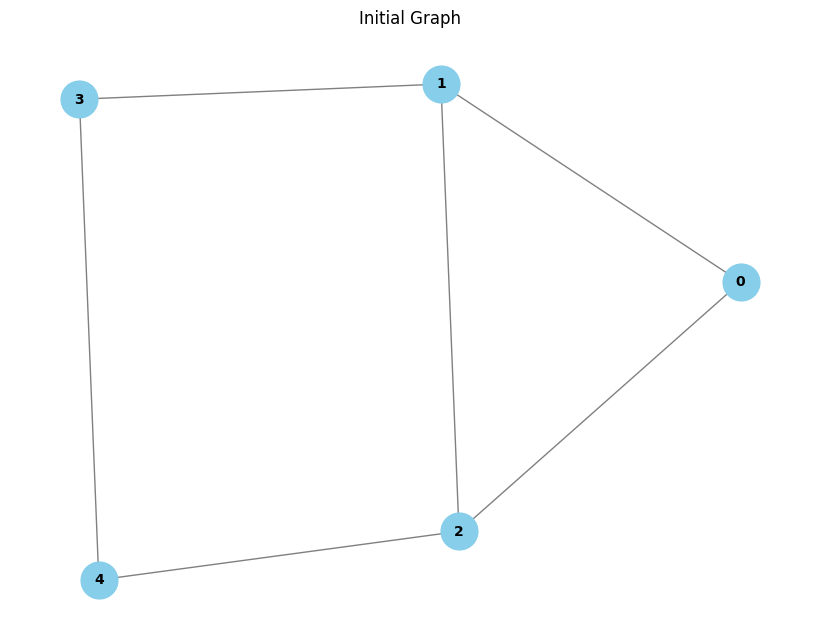

Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4})]

--- Iteration 1 ---
  Solving RMP with 5 columns...
  RMP Objective (sum of y_s, LP relaxed): 5.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 3}
  PSP objective value (sum of duals for this set): 2.0000
  Adding new column: {0, 3}. Total columns: 6

--- Iteration 2 ---
  Solving RMP with 6 columns...
  RMP Objective (sum of y_s, LP relaxed): 4.0000
  Dual variables (weights for PSP): [ 1.  1.  1. -0.  1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 4}
  PSP objective value (sum of duals for this set): 2.0000
  Adding new column: {0, 4}. Total columns: 7

--- Iteration 3 ---
  Solving RMP with 7 columns...
  RMP Objective (sum of y_s, LP relaxed): 4.0000
  Dual variables (weights for PSP): [-0.  1.  1.  1.  1.]


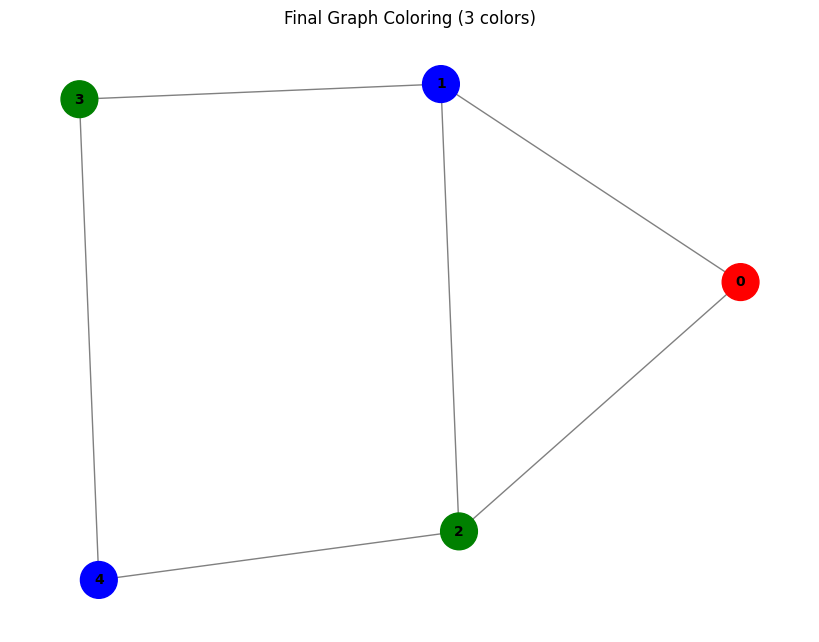






--- Summary for Graph 1 (5-Vertex Example) ---
Final number of colors: 3
Total columns generated: 9


In [4]:
# Example 1: The 5-vertex graph from the paper
G1 = nx.Graph()
G1.add_nodes_from(range(5)) # Nodes 0, 1, 2, 3, 4
G1.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
print("Running MVCP solver for Graph 1 (5-vertex example)...")
result1, columns1 = solve_mvcp_column_generation(G1, graph_name="5-Vertex Example")

print("\n\n" + "="*50 + "\n\n")



print("\n--- Summary for Graph 1 (5-Vertex Example) ---")
if result1 and result1.success: # Check if result1 is not None
    print(f"Final number of colors: {int(round(result1.fun))}")
    print(f"Total columns generated: {len(columns1)}")
elif result1:
    print(f"MVCP solution was not successful for Graph 1. Message: {result1.message}")
else:
    print("MVCP solution process for Graph 1 did not complete to produce a result object.")




Running MVCP solver for Graph 2 (Random 9-Vertex Graph, p=0.4)...
Solving MVCP for a graph with 9 vertices and 16 edges.


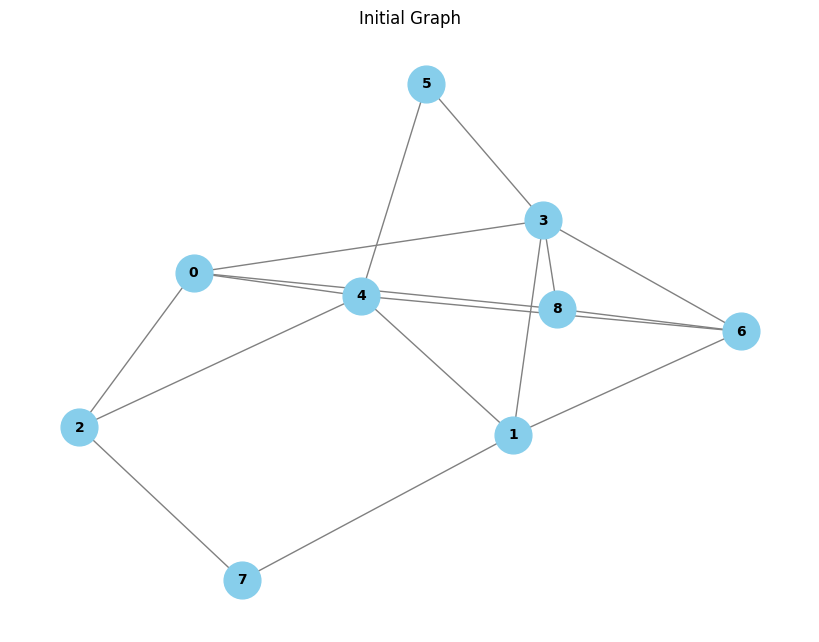

Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8})]

--- Iteration 1 ---
  Solving RMP with 9 columns...
  RMP Objective (sum of y_s, LP relaxed): 9.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {8, 1, 2, 5}
  PSP objective value (sum of duals for this set): 4.0000
  Adding new column: {8, 1, 2, 5}. Total columns: 10

--- Iteration 2 ---
  Solving RMP with 10 columns...
  RMP Objective (sum of y_s, LP relaxed): 6.0000
  Dual variables (weights for PSP): [ 1.  1.  1.  1.  1.  1.  1.  1. -2.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 5, 6, 7}
  PSP objective value (sum of duals for this set): 4.0000
  Adding new column: {0, 5, 6, 7}. Total columns: 11

--- Iteration 3 ---
  Solving RMP with 1

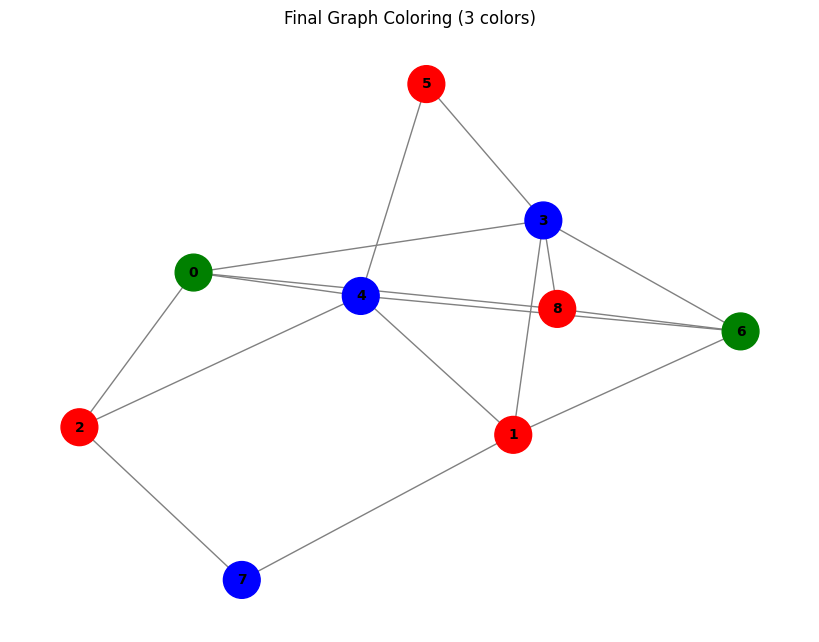


--- Summary for Graph 2 (Random Graph) ---
Final number of colors: 3
Total columns generated: 21


In [5]:
# Example 2: Random Graph (Erdos-Renyi)
num_random_nodes = 9
prob_edge = 0.4
seed_random = 42 # For reproducibility
G2 = nx.gnp_random_graph(num_random_nodes, prob_edge, seed=seed_random)
# Ensure G2 nodes are 0-indexed for simplicity with current mapping, gnp_random_graph does this.
print(f"Running MVCP solver for Graph 2 (Random {num_random_nodes}-Vertex Graph, p={prob_edge})...")
result2, columns2 = solve_mvcp_column_generation(G2, graph_name=f"Random {num_random_nodes}-Vertex (p={prob_edge})")


print("\n--- Summary for Graph 2 (Random Graph) ---")
if result2 and result2.success: # Check if result2 is not None
    print(f"Final number of colors: {int(round(result2.fun))}")
    print(f"Total columns generated: {len(columns2)}")
elif result2:
    print(f"MVCP solution was not successful for Graph 2. Message: {result2.message}")
else:
    print("MVCP solution process for Graph 2 did not complete to produce a result object.")

## Quantum CG Solver

Now we demonstrate how to leverage neutral atom quantum computer to be a good sampler for the PSP problem (equivalently solving the Maximum Weight Independent Set (MWIS) problem)

In [6]:
import warnings
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog, milp, OptimizeWarning

# Imports for the 'mis' package - Updated for current version
from mis import MISInstance, MISSolver, BackendConfig, BackendType
from mis.pipeline.config import SolverConfig
from mis.pipeline.pulse import BasePulseShaper
from mis.pipeline.embedder import BaseEmbedder
from mis.shared.types import MethodType # For solver methods like EAGER
from mis.data.dataloader import DataLoader
from mis.coloring.coloring import GraphColoringSolver

# Suppress verbose warnings from the solver and deprecated features if any
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

In [7]:
def plot_graph_with_coloring(graph, coloring, title="Graph Coloring", pos=None):
    """Plots the graph with nodes colored according to the final solution."""
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)  # Use a fixed seed for consistent layout
    
    # Create a color map for nodes based on the coloring dictionary
    # Default to a placeholder color if a node is not in the coloring (should not happen in a valid solution)
    # Using a list of colors to cycle through for different color indices
    color_palette = plt.cm.get_cmap('viridis', max(coloring.values()) + 1 if coloring else 1)
    
    node_colors_mapped = []
    for node in graph.nodes():
        if node in coloring:
            node_colors_mapped.append(color_palette(coloring[node]))
        else:
            node_colors_mapped.append('lightgrey') # Fallback for uncolored nodes

    plt.figure(figsize=(10, 8)) # Adjusted figure size
    nx.draw(graph, pos, with_labels=True, node_color=node_colors_mapped,
            node_size=700, font_size=10, font_weight='bold', edge_color='gray',
            width=1.5) # Edge width
    plt.title(title, fontsize=15)
    plt.show()

def solve_quantum_psp_with_mis(G, dual_vars):
    """
    Solves the Pricing Sub-Problem using the 'mis' quantum MIS sampler.

    Args:
        G (nx.Graph): The original graph.
        dual_vars (np.ndarray): The dual variables from the RMP.

    Returns:
        list[set]: A list of profitable independent sets found by the sampler.
    """
    # 1. Construct the subgraph G' with vertices having positive duals
    # These dual_vars correspond to nodes 0 to N-1 of G
    positive_dual_nodes = [node for node in G.nodes() if dual_vars[node] > 1e-5]

    if not positive_dual_nodes:
        print("  Quantum PSP (mis): No nodes with positive dual variables.")
        return []

    G_prime = G.subgraph(positive_dual_nodes).copy()
    
    # Node labels in G_prime are the same as in G.
    # The 'mis' package works on the graph structure. Weights are applied post-sampling.

    print(f"  Quantum PSP (mis): Solving for subgraph with {len(G_prime.nodes())} nodes and {len(G_prime.edges())} edges.")

    if not G_prime.nodes(): # If G_prime is empty after selection
        return []

    # Handle edgeless G_prime separately: MIS is all nodes.
    if not G_prime.edges():
        current_is = set(G_prime.nodes())
        if not current_is: # Should be caught by `if not G_prime.nodes()`
            return []
        total_weight = sum(dual_vars[node] for node in current_is)
        reduced_cost = 1 - total_weight
        if reduced_cost < -1e-5: # Profitable if weight > 1
        # if reduced_cost < 0.5: # Profitable if weight > 1
            print(f"    Found profitable IS (all nodes of edgeless G'): {current_is} with weight {total_weight:.4f}")
            return [current_is]
        else:
            # print(f"    IS (all nodes of edgeless G') not profitable. Weight: {total_weight:.4f}")
            return []

    # 2. Create an MISInstance for the subgraph
    instance = MISInstance(G_prime)

    # 3. Configure the MISSolver - Updated for current API
    config = SolverConfig(
        # method=MethodType.GREEDY,
        method=MethodType.EAGER,
        backend=BackendConfig(backend_type=BackendType.QUTIP),
        embedder=MyEmbedder(),
        pulse_shaper=MyPulseShaper(duration_us=4000),
        # pulse_shaper=DefaultPulseShaper(duration_us=4000),
        preprocessor=None,
        max_number_of_solutions=1,
        max_iterations=1,
    )

    solver = MISSolver(instance, config)
    
    """
    solver._solver._register.draw(
        # blockade_radius=solver.config.device.min_atom_distance,
        blockade_radius = 1.2*13,
        draw_graph=True,
        draw_half_radius=True)
    # config.pulse_shaper.generate(config, solver._solver.embedding()).draw()
    """

    
    solution_reports = []
    try:
        # .solve() returns a list of solutions directly
        solution_reports = solver.solve()
        # print('sol pulse: ', solver._solver._pulse)
        # print('sol report: ', solution_reports)
    except Exception as e:
        print(f"  Error during MIS solve: {e}")
        print("  Falling back to no new columns from this PSP iteration.")
        return [] # Return empty list on error

    if not solution_reports:
        print("    MIS solver returned no solutions.")
        return []

    print(f"    MIS solver returned {len(solution_reports)} solution candidate(s).")

    profitable_sets = []
    # Keep track of unique ISs (as sets of nodes) to avoid processing duplicates from reports
    processed_node_sets = set() 

    for report_idx, report in enumerate(solution_reports):
        # report.nodes contains the nodes of the independent set found
        # Node labels are preserved from G_prime, which are original labels from G.
        if not report.nodes: # Skip if an empty IS is reported
            continue
        
        # Create a canonical representation (sorted tuple) for the set of nodes
        # to ensure uniqueness when adding to processed_node_sets
        current_is_nodes_tuple = tuple(sorted(list(report.nodes)))
        
        if current_is_nodes_tuple in processed_node_sets:
            continue # Already processed this unique IS
        processed_node_sets.add(current_is_nodes_tuple)

        current_is_set = set(current_is_nodes_tuple)

        # 4. Calculate the "actual" weight of this IS using dual_vars
        total_weight = sum(dual_vars[node] for node in current_is_set)
        reduced_cost = 1 - total_weight # Profitability: sum(duals) > 1  => 1 - sum(duals) < 0
        
        # Using a small epsilon for floating point comparisons
        if reduced_cost < -1e-5: 
            frequency_info = f"(freq: {report.frequency})" if hasattr(report, 'frequency') else ""
            print(f"    Candidate {report_idx}: Found profitable IS: {current_is_set} with weight {total_weight:.4f} {frequency_info}")
            profitable_sets.append(current_is_set)
        # else:
        #     print(f"    Candidate {report_idx}: IS {current_is_set} not profitable. Weight: {total_weight:.4f}")
            
    return profitable_sets

## Application: Minimizing Antenna Frequencies as a Graph coloring problem

The dataset `antenna_Paris.csv` represents the geographical placement of 5G antennas across the city of Paris. Each antenna has a specific coverage range, and due to their spatial distribution, some antennas fall within each other’s coverage area. This creates the potential for signal interference between nearby antennas operating on the same frequency.

**Problem:** find an optimal way to assign frequencies to the antennas such that no two antennas within interfering distance use the same frequency. This is essentially a graph coloring problem, where antennas are represented as nodes in a graph, and edges connect nodes (antennas) that are within range of each other and could potentially interfere. The key question becomes: given this graph structure, how can we determine which sets of antennas can safely share the same frequency without causing interference? Solving this lays the foundation for designing an efficient, interference-free frequency distribution across the 5G antenna network in Paris.

In [9]:
import pandas as pd
import numpy as np
import pathlib
import os

# Load antenna data using the built-in DataLoader
# script_dir = os.path.dirname(os.path.abspath('.'))
csv_path = pathlib.Path('./datasets/coloring/antenna_Paris.csv')

# Initialize DataLoader with the antenna coordinates file
loader = DataLoader()
loader.load_from_csv_coordinates(csv_path)

# Define antenna range threshold (1.2 km)
antenna_range = 1.2  # kilometers

import pandas as pd
import numpy as np
import pathlib
import os

# Load antenna data using the built-in DataLoader
# Use direct path to the datasets directory
csv_path = pathlib.Path('./datasets/antenna_Paris.csv')

# Initialize DataLoader with the antenna coordinates file
loader = DataLoader()
loader.load_from_csv_coordinates(csv_path)

# Define antenna range threshold (1.2 km)
antenna_range = 1.2  # kilometers

# Get the antenna coordinates for display
df = pd.read_csv(csv_path, sep=';')
df[['latitude', 'longitude']] = df['coordonnees'].str.replace('"', '').str.split(',', expand=True).astype(float)

print(f"Loaded {len(loader.coordinates_dataset)} antenna coordinates")
print(f"Using antenna range: {antenna_range} km")

# Display sample of the data
df.head()

Graph has 126 nodes and 486 edges
Antennas within 1.2 km range of each other are connected by edges


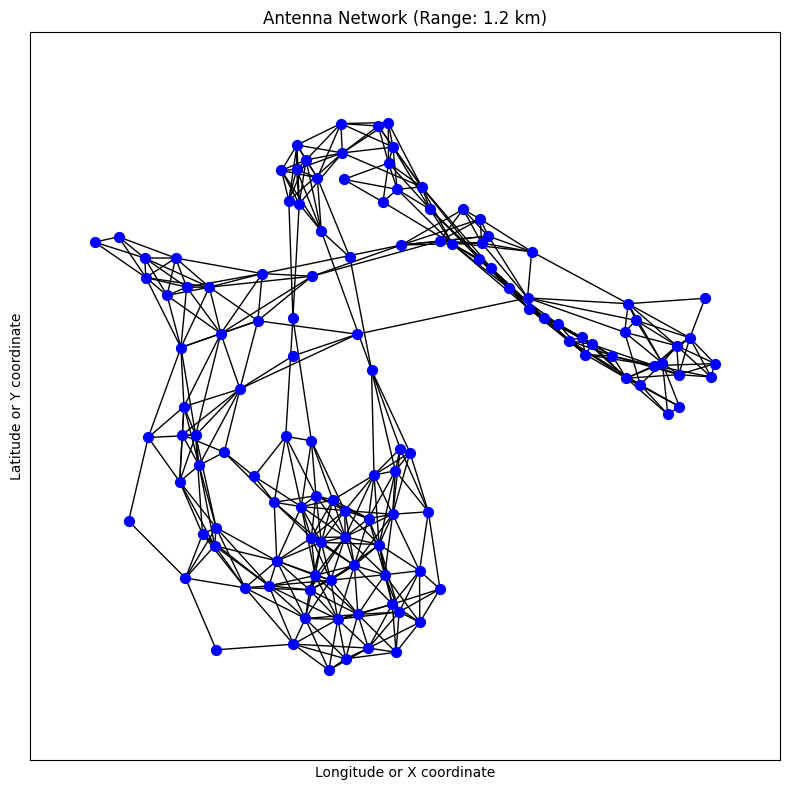

In [10]:
# Build MIS instance from coordinates using the built-in utility
# This creates a graph where nodes are antennas and edges connect antennas within range
mis_instance = loader.build_mis_instance_from_coordinates(antenna_range)
G = mis_instance.graph

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Antennas within {antenna_range} km range of each other are connected by edges")

# Plot the antenna network graph
pos = nx.get_node_attributes(G, 'pos')
if not pos:
    # If no positions are available, use spring layout
    pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, width=1, edge_color='black')
plt.title(f"Antenna Network (Range: {antenna_range} km)")
plt.xlabel("Longitude or X coordinate")
plt.ylabel("Latitude or Y coordinate")
plt.axis('equal')
plt.tight_layout()
plt.show()

Now let's pick a smaller connected subgraph to test our graph-coloring algorithm

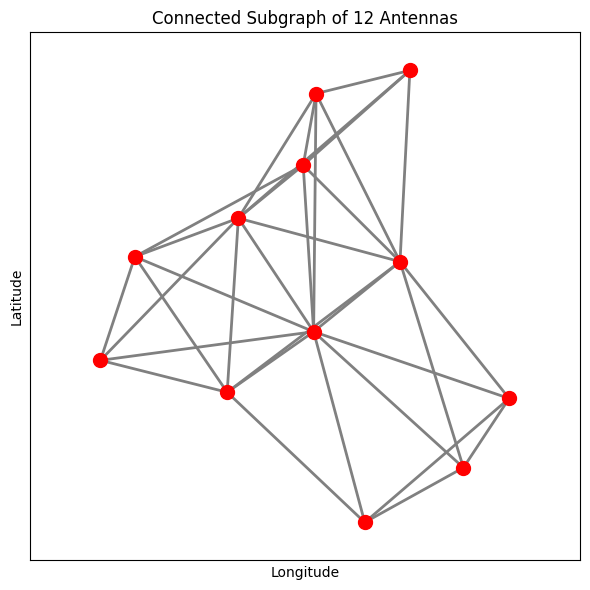

Selected 12 antenna nodes for the subgraph: [13, 5, 6, 7, 8, 12, 14, 23, 21, 22, 24, 1]


In [43]:
# Extract a connected subgraph of size 12 via BFS from a seed node
seed = list(G.nodes())[13]
selected_nodes = []
visited = set()
queue = [seed]

while queue and len(selected_nodes) < 12:
    node = queue.pop(0)
    if node not in visited:
        visited.add(node)
        selected_nodes.append(node)
        # add neighbors to queue
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                queue.append(neighbor)

# Induced subgraph on those 12 nodes
H = G.subgraph(selected_nodes)

# Extract positions for plotting - only include nodes in the subgraph
pos_all = nx.get_node_attributes(G, 'pos')
pos = {node: pos_all[node] for node in H.nodes() if node in pos_all}

# If no positions available, use spring layout for the subgraph
if not pos:
    pos = nx.spring_layout(H, seed=42)

# Plot the connected subgraph of size 12
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(H, pos, node_size=100, node_color='red')
nx.draw_networkx_edges(H, pos, edgelist=list(H.edges()), width=2, edge_color='gray')

# Draw edge labels (distances) for subgraph
# edge_labels = nx.get_edge_attributes(H, 'weight')
# formatted_labels = {edge: f"{weight:.2f} km" for edge, weight in edge_labels.items()}
# nx.draw_networkx_edge_labels(H, pos, edge_labels=formatted_labels, font_size=8)

plt.title("Connected Subgraph of 12 Antennas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print out the selected antennas for the subgraph
print(f"Selected {len(selected_nodes)} antenna nodes for the subgraph: {selected_nodes}")

In [44]:
def center_positions(positions):
    # Stack all positions into a single array
    all_coords = np.stack(list(positions.values()))  # shape: (n_nodes, 2)
    
    # Compute centroid
    centroid = np.mean(all_coords, axis=0)
    
    # Subtract centroid from each position
    centered_positions = {node: pos - centroid for node, pos in positions.items()}
    
    return centered_positions

### Solving PSP(MWIS) with Neutral Atom Quantum Computers

#### Neutral Atom Quantum Computers

Neutral atom arrays have emerged as a highly promising platform for quantum computation and simulation. In these systems, individual neutral atoms are trapped using optical tweezers, allowing for precise arrangement in 1D, 2D, or even 3D geometries. Quantum information is typically encoded in two electronic states of each atom: a ground state $|g\rangle$ and a highly excited Rydberg state $|r\rangle$. Lasers are used to drive transitions between these states ($\Omega$) and control their energy difference (detuning $\delta$).

A key feature is the strong, long-range interaction between atoms in the Rydberg state ($|r\rangle$). This interaction falls off rapidly with distance $R$ (typically as $C_6/R^6$).

#### The Blockade Mechanism

The strong Rydberg interaction leads to the **Rydberg blockade** effect: if one atom is excited to $|r\rangle$, the energy levels of nearby atoms are shifted significantly, preventing them from being resonantly excited to $|r\rangle$ by the same laser field. This blockade occurs within a characteristic radius $R_b$.

Effectively, this means that only atoms separated by a distance greater than $R_b$ can be simultaneously excited to the Rydberg state. This naturally implements the constraint of an **Independent Set** on a graph where atoms are vertices and edges connect atoms closer than $R_b$. Such a graph, where connectivity is determined solely by distance, is known as a **Unit-Disk Graph (UDG)**.

#### Antenna Frequencies and Graph Coloring
For this problem, we will assume that antennas within 1.2 km cannot be set to the same frequency. As a result, we will filter the antenna data and connect the antenna that are closer than 1.2 km to other antennas. Antenna problem now becomes a graph coloring (minimal vertex, MVCP) problem.

#### Using `maximum-independent-set` package
The `maximum-independent-set` package provide us a high-level api to solve the maximum independent set problems with neutral atom quantum computers/emulators. 

Below we customize a simple embedder `MyEmbedder` to just scaled the original locations. Notice that the default embedder usually rearrange the atom position (hopefully a UDG but not always doable) in order to solve the MIS problem more efficiently.


In [45]:
import pulser
from mis.pipeline.pulse import Register, Pulse

class MyEmbedder(BaseEmbedder):
    """
    Modified from Default embedder
    """

    def embed(self, instance: MISInstance, config: SolverConfig, backend) -> Register:
        device = backend.device()
        assert device is not None

        # Layout based on edges.
        positions = nx.get_node_attributes(instance.graph, 'pos')
        if not positions:
            # Use spring layout if no positions available
            positions = nx.spring_layout(instance.graph, iterations=100)
        positions = {k: np.array(v) for k, v in positions.items()}
        if len(positions) > 1:
            positions = center_positions(positions)

        # Rescale to ensure that minimal distances are respected.
        distances = [
            np.linalg.norm(positions[v1] - positions[v2])
            for v1 in instance.graph.nodes()
            for v2 in instance.graph.nodes()
            if v1 != v2
        ]
        # print('dist: ', distances)
        multiplier = 1 # default scaling factor
        if len(distances) != 0:
            min_distance = np.min(distances)
            # print('min dist: ', min_distance)
            # print('min atom dist: ', device.min_atom_distance)
            if min_distance < device.min_atom_distance:
                multiplier = device.min_atom_distance / min_distance
                # multiplier = 5
                positions = {i: v * multiplier for (i, v) in positions.items()}
                # print('multiplier: ', multiplier)
                # print('pos[scaled]: ', positions)

        # Store the scaling multiplier in the graph metadata for use by MyPulseShaper
        instance.graph.graph['scaling_multiplier'] = multiplier

        # Finally, prepare register.
        return Register(
            qubits={f"q{node}": pos for (node, pos) in positions.items()}
        )


We also need to customize the Pulse (that controls the dynamics of the atoms in the system). For our use case, we want to fix the blockade radius to 1.2 km (up to some scale suitable for the emulator/hardware)

In [46]:
from pulser import InterpolatedWaveform, Pulse as PulserPulse

class MyPulseShaper(BasePulseShaper):
    """
    A simple pulse shaper.
    """

    def generate(self, config: SolverConfig, register: Register, backend, instance) -> Pulse:
        """
        Method to return a simple constant waveform pulse
        """
        device = backend.device()
        assert device is not None

        duration_us = self.duration_us
        if duration_us is None:
            duration_us = device.max_sequence_duration

        # bounds = self._calc_bounds(reg=register, device=device)
        # rb = 1.2*13  # μm
        scaling_multiplier = instance.graph.graph.get('scaling_multiplier', 13)
        rb = 1.2 * scaling_multiplier  # μm
        # omega = pulser.AnalogDevice.rabi_from_blockade(rb)  # rad/μs
        omega = device.rabi_from_blockade(rb)  # rad/μs
        # print(device.print_specs())
        print(f"Rydberg blockade radius for Ω={omega} rad/μs: {rb} μm")
        Delta = 2 * omega

        amplitude = InterpolatedWaveform(
            duration_us, [1e-9, omega, 1e-9]
        )  # FIXME: This should be 0, investigate why it's 1e-9
        detuning = InterpolatedWaveform(
            duration_us, [-Delta, 0, Delta]
        )
        rydberg_pulse = PulserPulse(amplitude, detuning, 0)
        # Pulser overrides PulserPulse.__new__ with an exotic type, so we need
        # to help mypy.
        assert isinstance(rydberg_pulse, PulserPulse)

        return rydberg_pulse

In [47]:
def solve_mvcp_column_generation_quantum(G, graph_name="Graph"):
    """
    Solves the MVCP using column generation with a quantum pricing solver ('mis' package).
    """
    num_nodes = G.number_of_nodes()
    if num_nodes == 0:
        print("Graph is empty. No coloring needed.")
        return None, []
        
    node_list = list(G.nodes()) 
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    # idx_to_node = {i: node for i, node in enumerate(node_list)} # Not strictly needed if using node_list

    initial_columns = [frozenset([node]) for node in node_list]
    
    A = np.zeros((num_nodes, len(initial_columns)))
    columns_internal = [] 

    for j, col_nodes in enumerate(initial_columns):
        columns_internal.append(col_nodes)
        for node_label in col_nodes:
            A[node_to_idx[node_label], j] = 1
            
    max_cg_iterations = 20 
    for it in range(max_cg_iterations):
        print(f"\n--- Iteration {it+1} ---")
        
        c_rmp = np.ones(len(columns_internal)) 
        b_rmp = np.ones(num_nodes)          
        
        # rmp_sol = linprog(c_rmp, A_eq=A, b_eq=b_rmp, bounds=(0, None), method='highs')
        bounds_rmp = [(0, 1) for _ in range(len(columns_internal))]
        # rmp_sol = linprog(c_rmp, A_eq=A, b_eq=b_rmp, bounds=(0, None), method='highs')
        rmp_sol = linprog(c_rmp, A_eq=A, b_eq=b_rmp, bounds=bounds_rmp, method='highs')
        
        if not rmp_sol.success:
            print(f"RMP solve failed in iteration {it+1}. Status: {rmp_sol.status}, Message: {rmp_sol.message}")
            break

        # Correctly access dual variables for equality constraints
        if hasattr(rmp_sol, 'eqlin') and hasattr(rmp_sol.eqlin, 'marginals'):
            dual_vars_indexed = rmp_sol.eqlin.marginals
        else:
            # Fallback or error if duals are not found as expected
            print("Error: Dual variables (eqlin.marginals) not found in RMP solution.")
            print("RMP solution object:", rmp_sol)
            break # Cannot proceed without duals
        
        if dual_vars_indexed is None or len(dual_vars_indexed) != num_nodes:
            print(f"Error: Dual variables have unexpected shape or are None. Expected length {num_nodes}, got {len(dual_vars_indexed) if dual_vars_indexed is not None else 'None'}")
            break

        dual_vars_for_psp = {node_list[i]: dual_vars_indexed[i] for i in range(num_nodes)}

        print(f"RMP solved. Objective (sum of y_s): {rmp_sol.fun:.4f}")
        print(f"  Dual variables (weights for PSP): {np.round(dual_vars_indexed, 4)}")

        new_profitable_columns = solve_quantum_psp_with_mis(G, dual_vars_for_psp)
        
        added_count = 0
        if not new_profitable_columns:
            print("\nConvergence likely: PSP found no new profitable columns.")
            break
        
        for new_col_nodes in new_profitable_columns: 
            if frozenset(new_col_nodes) not in columns_internal: 
                columns_internal.append(frozenset(new_col_nodes))
                
                new_A_col_vec = np.zeros((num_nodes, 1))
                for node_label in new_col_nodes:
                    if node_label in node_to_idx: 
                         new_A_col_vec[node_to_idx[node_label], 0] = 1
                A = np.hstack((A, new_A_col_vec))
                added_count += 1
        
        if added_count == 0:
            print("\nConvergence reached: All profitable columns found by PSP were already in RMP.")
            break
            
        print(f"Added {added_count} new unique column(s) to the RMP.")

    if it == max_cg_iterations -1:
        print("\nMax CG iterations reached.")

    print(f"\nSolving final MILP with {len(columns_internal)} columns...")
    c_milp = np.ones(A.shape[1])
    integrality_milp = np.ones(A.shape[1]) 
    # bounds_milp = [(0, 1)] * A.shape[1] 
    bounds_milp = ([0] * A.shape[1], [1] * A.shape[1])

    
    
    milp_constraints = [(A, b_rmp, b_rmp)] 

    milp_result = milp(c=c_milp,
                       integrality=integrality_milp,
                       bounds=bounds_milp,
                       constraints=milp_constraints)

    if milp_result.success:
        final_num_colors = int(round(milp_result.fun))
        print(f"Final number of colors (MILP): {final_num_colors}")
        
        coloring_solution = {} 
        color_idx_counter = 0
        for i, y_val in enumerate(milp_result.x):
            if y_val > 0.99: 
                for node_label_in_col in columns_internal[i]:
                    coloring_solution[node_label_in_col] = color_idx_counter
                color_idx_counter += 1
        
        plot_graph_with_coloring(G, coloring_solution, title=f"{graph_name} - Final Coloring ({final_num_colors} colors)")
        return milp_result, columns_internal
    else:
        print("Final MILP solution failed.")
        print(f"MILP status: {milp_result.status}, Message: {milp_result.message}")
        return None, columns_internal

## [Debug Section] Test the configurator

In [48]:
import pulser

instance_test = MISInstance(H)

# 3. Configure the MISSolver
# Using QutipBackend for simulation as shown in Tutorial 1a.
# MethodType.EAGER is a common choice.
# max_iterations for SolverConfig might influence classical heuristics or repetitions.
# For quantum backends, the number of shots is usually handled internally or by backend config.
# Tutorial 1a uses max_iterations=1. Let's stick to that for simplicity.
# The .result() from solve() should give a list of solutions (from shots).
config_test = SolverConfig(
    # method=MethodType.GREEDY,
    method=MethodType.EAGER,
    backend=BackendConfig(backend_type=BackendType.QUTIP),
    embedder=MyEmbedder(),
    pulse_shaper=MyPulseShaper(duration_us=4000),
    # pulse_shaper=DefaultPulseShaper(duration_us=4000),
    preprocessor=None,
    max_number_of_solutions=5,
    max_iterations=1,
)

solver_test = MISSolver(instance_test, config_test)
# print('device: ', solver_test.config.device, ' max duration: ', solver_test.config.device.max_sequence_duration)
# print('device spec: ', solver.config.device.print_specs())
# print('solver: ', solver._solver)
print('embedding: ', solver_test._solver.embedding())
# print(config_test.preprocessor)

embedding:  Register({'q0': array([ 5.51345057, 14.22188802]), 'q1': array([-1.49113463, 10.14167287]), 'q2': array([-3.46268572,  4.94028291]), 'q3': array([5.52749888, 8.30064638]), 'q4': array([5.12237693, 1.1258552 ]), 'q5': array([-10.63503116,   4.25547408]), 'q6': array([-0.35505464, -2.33109404]), 'q7': array([10.68912815, -7.93567244]), 'q8': array([  1.01366816, -14.0016718 ]), 'q9': array([  7.32686635, -11.63637448]), 'q10': array([-13.15353401,  -2.05251019]), 'q11': array([-6.09554888, -5.02849652])})


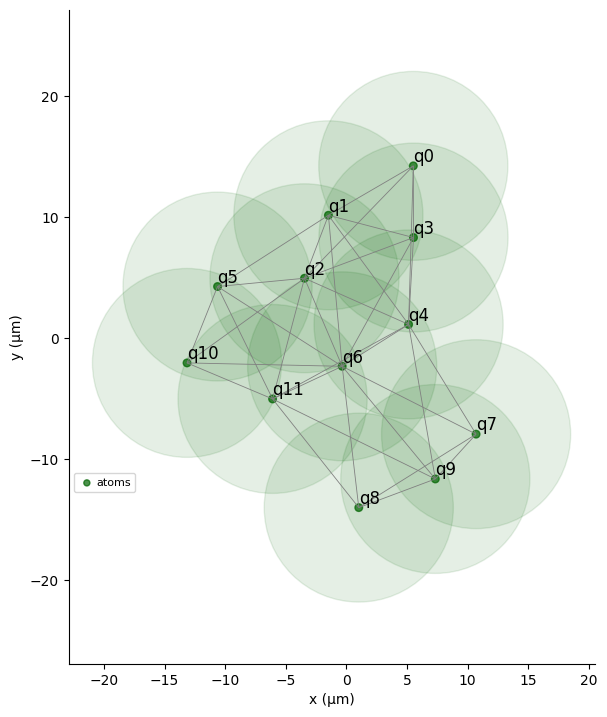

Rydberg blockade radius for Ω=0.018081459877036573 rad/μs: 19.055670982697315 μm


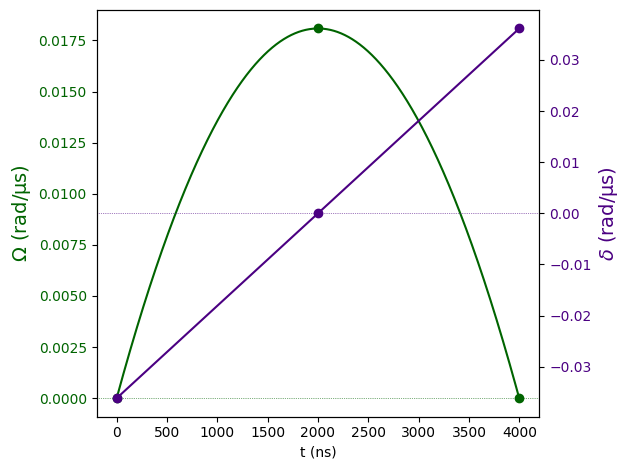

Rydberg blockade radius for Ω=0.04800916695339138 rad/μs: 16.193564890817534 μm
Quantum solver solutions: [<mis.shared.types.MISSolution object at 0x13a3ad0f0>, <mis.shared.types.MISSolution object at 0x13a3acf10>, <mis.shared.types.MISSolution object at 0x13a3ad000>, <mis.shared.types.MISSolution object at 0x13a3ad090>, <mis.shared.types.MISSolution object at 0x13a3acfa0>]


In [49]:
solver_test._solver._register.draw(
    # blockade_radius=solver.config.device.min_atom_distance,
    blockade_radius = 1.2*13,
    draw_graph=True,
    draw_half_radius=True)
config_test.pulse_shaper.generate(config_test, solver_test._solver.embedding(), solver_test._solver.backend, instance_test).draw()

# %%
solutions = solver_test.solve()
print("Quantum solver solutions:", solutions)

In [41]:
solutions = solver_test.solve()
print("Quantum solver solutions:", solutions)

Rydberg blockade radius for Ω=0.00023033809568475213 rad/μs: 39.43079490287261 μm
Quantum solver solutions: [<mis.shared.types.MISSolution object at 0x13a542b00>]


### Quantum CG Solver

Running Quantum CG MVCP solver (mis package) for the 12-vertex sub-graph...
Graph nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (2, 10), (2, 11), (3, 4), (3, 6), (4, 7), (4, 6), (4, 9), (4, 11), (5, 6), (5, 10), (5, 11), (6, 7), (6, 10), (6, 8), (6, 9), (6, 11), (7, 8), (7, 9), (8, 9), (8, 11), (10, 11)]

--- Iteration 1 ---
RMP solved. Objective (sum of y_s): 12.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Quantum PSP (mis): Solving for subgraph with 12 nodes and 34 edges.
Rydberg blockade radius for Ω=0.02876897222776927 rad/μs: 17.636366006289165 μm
    MIS solver returned 1 solution candidate(s).
    Candidate 0: Found profitable IS: {1, 10, 9} with weight 3.0000 (freq: 0.974)
Added 1 new unique column(s) to the RMP.

--- Iteration 2 ---
RMP solved. Objective (sum of y_s): 10.0000
  Dual variables (weights for PSP): [ 1.  1.  1.  1.  1

/var/folders/ct/wcw6wkbj1_d981qgd820zm3w0000gp/T/ipykernel_74208/4137985840.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('viridis', max(coloring.values()) + 1 if coloring else 1)


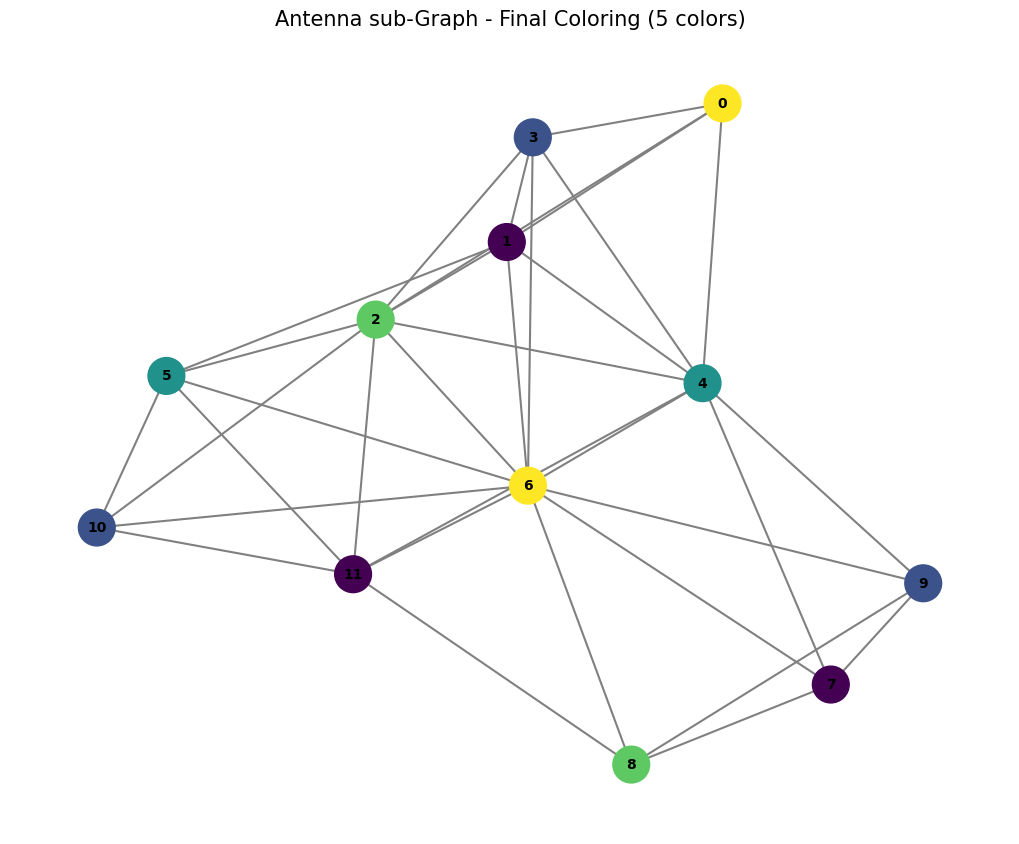


--- Summary ---
Final number of colors: 5
Total unique columns generated: 20


In [50]:
# Ensure nodes are integers if gnp_random_graph doesn't guarantee it (it does)
H = nx.convert_node_labels_to_integers(H, first_label=0)


print(f"Running Quantum CG MVCP solver (mis package) for the 12-vertex sub-graph...")
print(f"Graph nodes: {list(H.nodes())}, Edges: {list(H.edges())}")

final_milp_res, final_cols = solve_mvcp_column_generation_quantum(H, graph_name=f"Antenna sub-Graph")

if final_milp_res and final_milp_res.success:
    print("\n--- Summary ---")
    print(f"Final number of colors: {int(round(final_milp_res.fun))}")
    print(f"Total unique columns generated: {len(final_cols)}")
elif final_milp_res: # MILP object exists but not successful
    print("\n--- Summary ---")
    print(f"MVCP solution was not successful (MILP failed). Status: {final_milp_res.status}")
else: # No MILP object returned (e.g. RMP failed critically)
    print("\n--- Summary ---")
    print("MVCP solution process did not complete successfully.")

### Check with Classical Solver

Solving MVCP for a graph with 12 vertices and 34 edges.


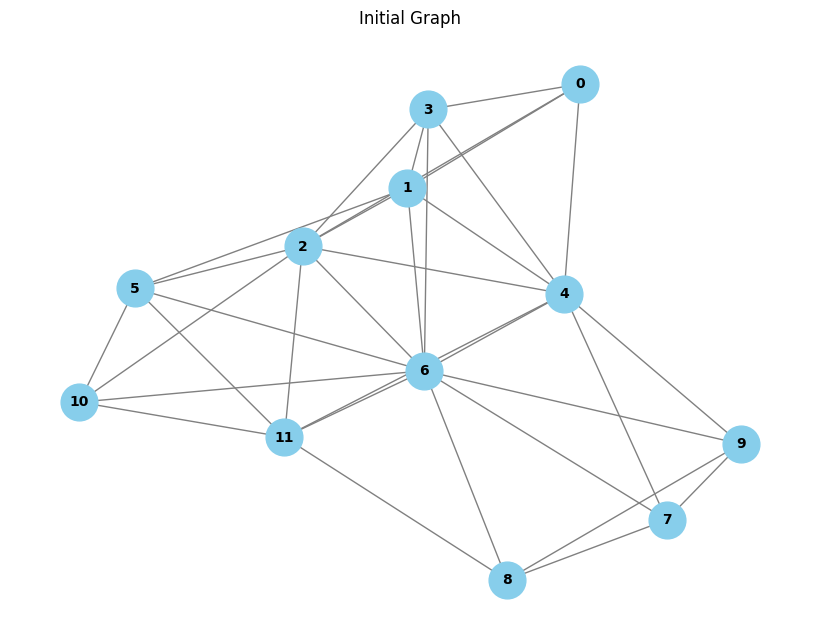

Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8}), frozenset({9}), frozenset({10}), frozenset({11})]

--- Iteration 1 ---
  Solving RMP with 12 columns...
  RMP Objective (sum of y_s, LP relaxed): 12.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 10, 7}
  PSP objective value (sum of duals for this set): 3.0000
  Adding new column: {0, 10, 7}. Total columns: 13

--- Iteration 2 ---
  Solving RMP with 13 columns...
  RMP Objective (sum of y_s, LP relaxed): 10.0000
  Dual variables (weights for PSP): [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 5, 7}
  PSP objective value (sum of duals for this set): 3.0000
  Adding new column: {0, 5,

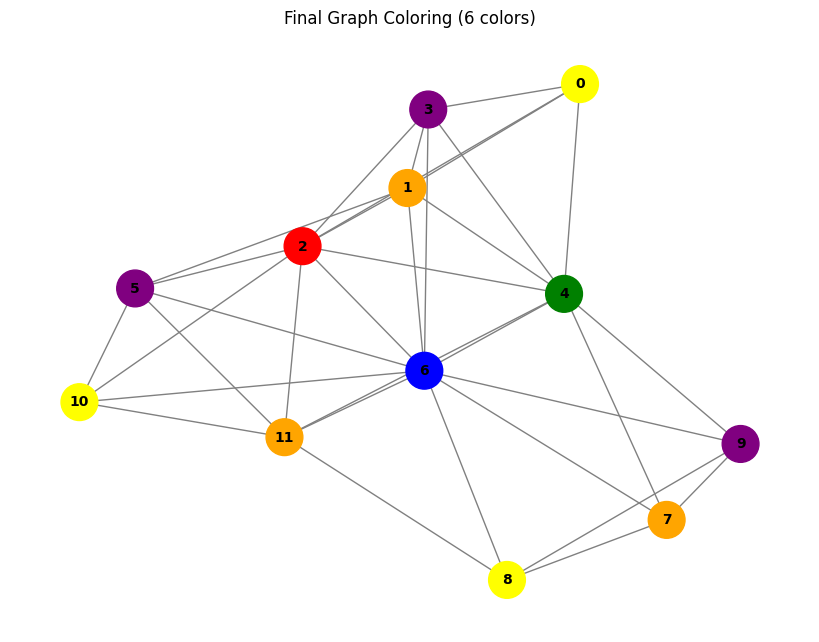


--- Summary ---
Final number of colors: 6
Total unique columns generated: 18


In [51]:
final_milp_res_c, final_cols_c = solve_mvcp_column_generation(H, graph_name=f"12-vertex subGraph")

if final_milp_res_c and final_milp_res_c.success:
    print("\n--- Summary ---")
    print(f"Final number of colors: {int(round(final_milp_res_c.fun))}")
    print(f"Total unique columns generated: {len(final_cols_c)}")
elif final_milp_res_c: # MILP object exists but not successful
    print("\n--- Summary ---")
    print(f"MVCP solution was not successful (MILP failed). Status: {final_milp_res_c.status}")
else: # No MILP object returned (e.g. RMP failed critically)
    print("\n--- Summary ---")
    print("MVCP solution process did not complete successfully.")

We see that actually our Quantum CG solver find better solution than the classical CG method.